In [1]:
import os
import glob
import skimage
from skimage import filters as sk_filt
from skimage import feature as sk_feat
from skimage import img_as_ubyte
from skimage.io import imsave, imread
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
img_dir = '../images/'
all_image_names = ['image_' + str(i) for i in range(118)]
ext_dict = {
    'og': 'original/',
    'all': 'all_edges/',
    '0': '0/',
    '30': '30/',
    '60': '60/',
    '90': '90/',
    '120': '120/',
    '150': '150/'
}
orientations = [0, 30, 60, 90, 120, 150]

In [3]:
for ext in ext_dict.values():
    if not os.path.exists(img_dir + ext):
        os.makedirs(img_dir + ext)

In [4]:
def get_paths(dir, image_type='png'):
    """
    get the file name/path of all the files within a folder.
        e.g. glob.glob("/home/adam/*/*.txt").
    Use glob.escape to escape strings that are not meant to be patterns
        glob.glob(glob.escape(directory_name) + "/*.txt")
    """
    end = "/*." + image_type
    file_paths = glob.glob(glob.escape(dir) + end)
    return file_paths

In [5]:
def angle(dx, dy, left_is_zero=False, as_degree=True):
    a = np.mod(np.arctan2(dy, dx), 2*np.pi)
    
    if not left_is_zero:
        a = np.pi - a
        
    if as_degree:
        a = a * 180 / np.pi

    if not left_is_zero:
        a += 90

    if a.any() > 180:
        a = 180 - a
        
    return a
    
def get_image_angle(
    file,
    guass_sigma = 25, # for blurring
    guass_truncate = 1/5, # for blurring
    canny_sigma = 1, # for edge 
    grad_fns='farid', # e.g. 'sobel','scharr', 'prewitt'
    angle_left_is_zero = False, # zero degrees is on left
    angle_as_degree = True, # convert radian to degree, required for now
    angle_set = [0, 30, 60, 90, 120, 150], # in degrees for now
    angle_fudge = 15 # fudge angle to compare with set
):
    # assert angle_as_degree, 'Only allow "angle_as_degree=True" at the moment'
    
    img = skimage.io.imread(file)
    blur = sk_filt.gaussian(img, sigma=guass_sigma, truncate=guass_truncate)
    edges = skimage.feature.canny(blur, sigma=canny_sigma)
    
    params = dict(
        guass_sigma = guass_sigma,
        guass_truncate = guass_truncate,
        canny_sigma = canny_sigma,
        grad_fns = grad_fns,
        angle_left_is_zero = angle_left_is_zero,
        angle_as_degree = angle_as_degree,
        angle_set = angle_set,
        angle_fudge = angle_fudge,
    )
    
    output = dict(
        file = file,
        params = params,
        preproc = dict(
            orig = img,
            blur = blur,
            edges = edges,
        ),
        angles = dict(),
    )

    mask_edge = sk_filt.gaussian(edges, sigma=guass_sigma*2, truncate=guass_truncate) > 0
    
    if isinstance(grad_fns, str):
        grad_fns = [grad_fns]
    
    for grad_fn in grad_fns:
        dx_fn = getattr(sk_filt, grad_fn + '_h') # e.g. 'skimage.filters.farid_h'
        dy_fn = getattr(sk_filt, grad_fn + '_v') # e.g. 'skimage.filters.farid_v'

        angles = angle(
            dx = dx_fn(edges),
            dy = dy_fn(edges),
            left_is_zero = angle_left_is_zero,
            as_degree = angle_as_degree,
        )
        
        angles_dict = dict(
            angles = angles
        )
        
        angles_dict.update({
            a: np.abs(angles - a) <= angle_fudge
            for a in angle_set
        })
        
        output['angles'][grad_fn] = angles_dict
        
    return output
        

In [6]:
results = []
edge_scores_normalized_by_all = {}
edge_scores_normalized_by_sum = {}

In [7]:
originals = get_paths(img_dir + ext_dict['og'])

In [8]:
for file in originals:
    results.append(get_image_angle(
        file = file,
        grad_fns='farid' # farid seems sufficient
    ))

In [9]:
for i in range(len(originals)):
    result = results[i]
    file = result['file']
    save_img_name = file.split('/')[-1]
    # Get all edges
    all_edges = result['preproc']['edges']
    # Sum pixels to get total edge score
    all_edges_score = np.mean(all_edges)
    sum_edges_score = 0
    # Save result image containing all edges
    imsave(os.path.join(img_dir, ext_dict['all'] + save_img_name), img_as_ubyte(all_edges), check_contrast=False)
    # Initialize dicts for each image
    edge_scores_normalized_by_all[save_img_name] = {}
    edge_scores_normalized_by_sum[save_img_name] = {}
    # For each angle...
    for o in orientations:
        # Save result image containing only edges in this angle
        filtered_edges = result['angles']['farid'][o]
        imsave(os.path.join(img_dir, ext_dict[str(o)] + save_img_name), img_as_ubyte(filtered_edges), check_contrast=False)
        filtered_edge_score = np.mean(filtered_edges)
        sum_edges_score += filtered_edge_score
        filtered_edge_score_normalized_by_all = filtered_edge_score / all_edges_score
        edge_scores_normalized_by_all[save_img_name][o] = filtered_edge_score_normalized_by_all
    for o in orientations:
        filtered_edges = result['angles']['farid'][o]
        filtered_edge_score = np.mean(filtered_edges)
        # if i == 0:
        #     print(o)
        #     print(filtered_edge_score)
        #     print(sum_edges_score)
        filtered_edge_score_normalized_by_sum = filtered_edge_score / sum_edges_score
        edge_scores_normalized_by_sum[save_img_name][o] = filtered_edge_score_normalized_by_sum

In [10]:
# convert edge_scores_normalized_by_sum to dataframe
df_edge_scores_normalized_by_sum = pd.DataFrame(edge_scores_normalized_by_sum)
df_edge_scores_normalized_by_sum = df_edge_scores_normalized_by_sum.transpose()
df_edge_scores_normalized_by_sum.columns = orientations
# convert iamge names to integers
df_edge_scores_normalized_by_sum.index = [int(i.split('.')[0].split('_')[1]) for i in df_edge_scores_normalized_by_sum.index]
# order rows by image name
df_edge_scores_normalized_by_sum = df_edge_scores_normalized_by_sum.sort_index()

In [11]:
# add a row for the average and mean of each column
# df_edge_scores_normalized_by_sum.loc['mean'] = df_edge_scores_normalized_by_sum.mean()
# df_edge_scores_normalized_by_sum.loc['variance'] = df_edge_scores_normalized_by_sum.var()

In [12]:
df_edge_scores_normalized_by_sum

0         30        60        90        120       150
0    0.140268  0.113346  0.117948  0.158095  0.234487  0.235856
1    0.111325  0.153892  0.183915  0.229867  0.176943  0.144058
2    0.178618  0.139028  0.134122  0.158725  0.197833  0.191674
3    0.114039  0.130004  0.161034  0.209393  0.203055  0.182475
4    0.099571  0.169813  0.222011  0.233712  0.134635  0.140258
..        ...       ...       ...       ...       ...       ...
113  0.613158  0.158085  0.066591  0.025282  0.046567  0.090316
114  0.025913  0.051173  0.124503  0.603462  0.126572  0.068376
115  0.179647  0.207055  0.145380  0.094193  0.165506  0.208220
116  0.154026  0.155797  0.151183  0.143921  0.195839  0.199233
117  0.202798  0.173396  0.155468  0.143786  0.154827  0.169726

[118 rows x 6 columns]

In [13]:
# save df_edge_scores_normalized_by_sum to csv
df_edge_scores_normalized_by_sum.to_csv(
    '../data/edge_scores_normalized_by_sum.csv')

### Picking two cells to validate the preferred orientation

In [14]:
# Experiment Id	511510695	Cell Id	517503450
# 90 degrees
subset_results = []
for r in results:
    if ('image_106.png' in r['file'] or 'image_114.png' in r['file']):
        subset_results.append(r)

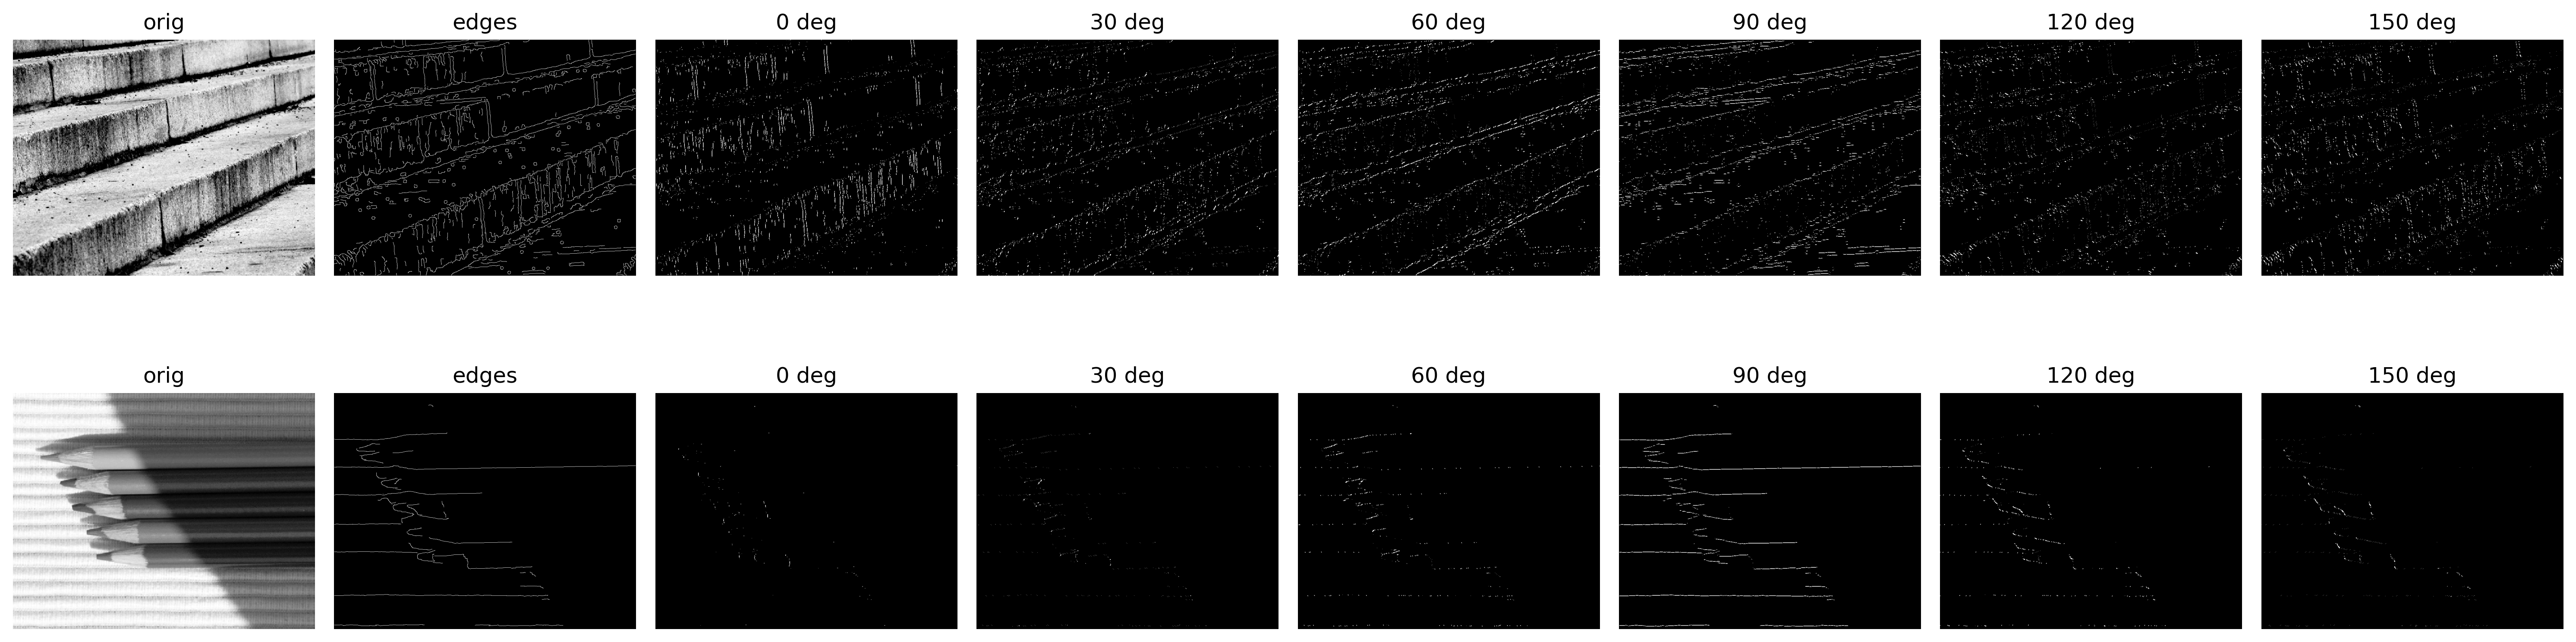

In [15]:
num_rows = len(subset_results)
num_cols = len(list(subset_results[0]['angles'].values())[0]) + 1

fig, axs = plt.subplots(
    num_rows, num_cols,
    figsize=(20,8), 
    sharex=True, sharey=True, 
    layout='tight',
    dpi=300
)
grad_fn_name = 'farid'
for row_idx, result in enumerate(subset_results):
    ax = axs[row_idx, 0]
    ax.imshow(result['preproc']['orig'], cmap='Greys_r')
    ax.set_title('orig')
    ax.set_axis_off()
    
    ax = axs[row_idx, 1]
    ax.imshow(result['preproc']['edges'], cmap='Greys_r')
    ax.set_title('edges')
    ax.set_axis_off()
    
    for pre_col_idx, (ttl, img) in enumerate(result['angles'][grad_fn_name].items()):
        if ttl == 'angles':
            continue
            
        ax = axs[row_idx, pre_col_idx + 1]
        img_obj = ax.imshow(img, cmap='Greys_r')
        ax.set_title(f'{ttl} deg')
        ax.set_axis_off()

In [16]:
subset_df = df_edge_scores_normalized_by_sum.loc[[106, 114]]
subset_df.loc['mean'] = subset_df.mean()
subset_df.loc['variance'] = subset_df.var()
subset_df

0         30        60        90        120       150
106       0.193216  0.144412  0.191657  0.215414  0.121503  0.133797
114       0.025913  0.051173  0.124503  0.603462  0.126572  0.068376
mean      0.109564  0.097793  0.158080  0.409438  0.124038  0.101087
variance  0.006998  0.002173  0.001127  0.037645  0.000006  0.001070

In [17]:
# Experiment Id	511510917	Cell Id	517442396
# 60 degrees
subset_results_2 = []
for r in results:
    if ('image_28.png' in r['file'] or 'image_86.png' in r['file']):
        subset_results_2.append(r)

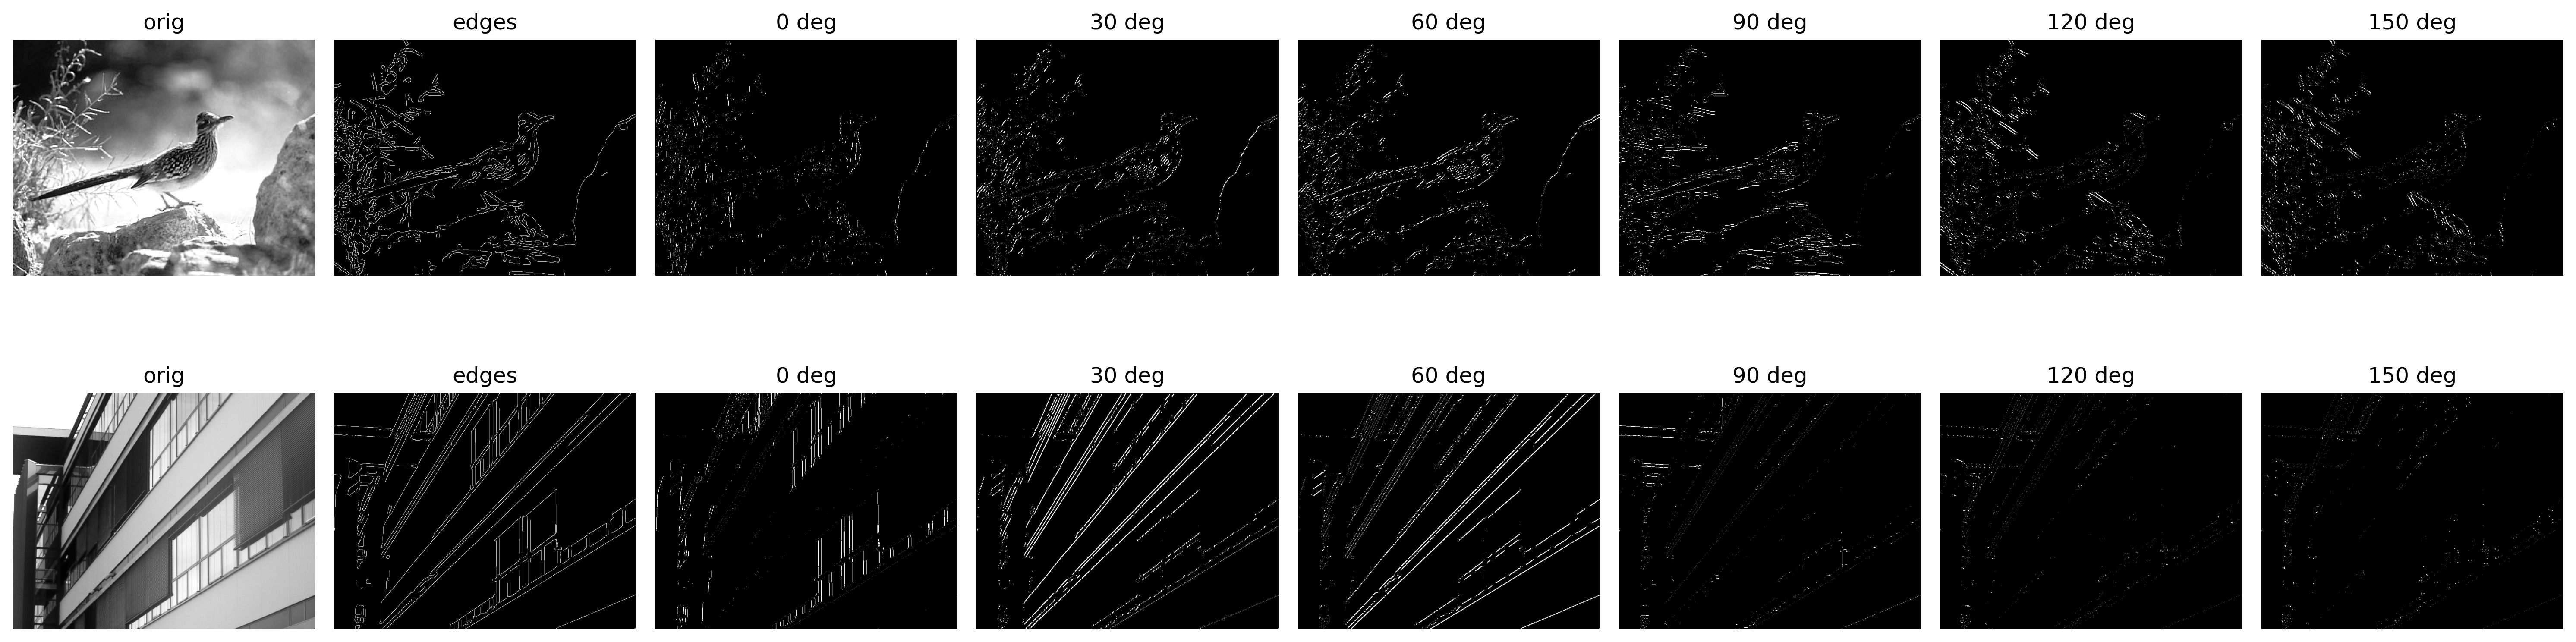

In [18]:
num_rows = len(subset_results_2)
num_cols = len(list(subset_results_2[0]['angles'].values())[0]) + 1

fig, axs = plt.subplots(
    num_rows, num_cols,
    figsize=(20,8), 
    sharex=True, sharey=True, 
    layout='tight',
    dpi=300
)
grad_fn_name = 'farid'
for row_idx, result in enumerate(subset_results_2):
    ax = axs[row_idx, 0]
    ax.imshow(result['preproc']['orig'], cmap='Greys_r')
    ax.set_title('orig')
    ax.set_axis_off()
    
    ax = axs[row_idx, 1]
    ax.imshow(result['preproc']['edges'], cmap='Greys_r')
    ax.set_title('edges')
    ax.set_axis_off()
    
    for pre_col_idx, (ttl, img) in enumerate(result['angles'][grad_fn_name].items()):
        if ttl == 'angles':
            continue
            
        ax = axs[row_idx, pre_col_idx + 1]
        img_obj = ax.imshow(img, cmap='Greys_r')
        ax.set_title(f'{ttl} deg')
        ax.set_axis_off()

In [19]:
subset_df_2 = df_edge_scores_normalized_by_sum.loc[[28, 86]]
subset_df_2.loc['mean'] = subset_df_2.mean()
subset_df_2.loc['variance'] = subset_df_2.var()
subset_df_2

0         30        60        90        120       150
28        0.117445  0.179726  0.205388  0.187521  0.166642  0.143279
86        0.165173  0.415729  0.315265  0.048238  0.031086  0.024510
mean      0.141309  0.297727  0.260326  0.117879  0.098864  0.083894
variance  0.000569  0.013924  0.003018  0.004850  0.004594  0.003527